In [491]:
import  numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from math import sqrt
import matplotlib.pyplot as plt
import warnings

In [440]:
warnings.filterwarnings("ignore")

### Data Load

In [466]:
df=pd.read_csv('diabetes.csv')

In [467]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [468]:
#y label is outcome

In [469]:
df = df[:200]

In [470]:
df.shape

(200, 9)

In [399]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000
mean,4.610000,117.940000,68.070000,19.900000,74.350000,30.996000,0.46893,34.420000,0.370000
std,3.589814,33.712636,22.009298,16.306719,126.446649,9.611734,0.37117,11.212529,0.485237
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.10200,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,25.300000,0.24800,25.750000,0.000000
50%,4.000000,112.500000,72.000000,21.500000,0.000000,31.800000,0.34300,31.000000,0.000000
75%,7.000000,139.000000,80.000000,32.250000,110.000000,37.225000,0.58375,42.000000,1.000000
max,15.000000,197.000000,110.000000,60.000000,846.000000,49.700000,2.28800,60.000000,1.000000


In [471]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [472]:
#pre processing

In [473]:
def outlier_remover(df_num,df):
    Q1 = df_num.quantile(0.25)
    Q3 = df_num.quantile(0.75)
    IQR=df_num.quantile(0.75)-df_num.quantile(0.25)
    lower_bound = Q1-IQR
    upper_bound=Q3+IQR
    df=df[~((df_num<lower_bound)|(df_num>upper_bound)).any(axis=1)]
    return df

In [474]:
df =outlier_remover(df,df)

In [475]:
X=df.drop('Outcome',axis=1)
y=df.Outcome

In [476]:
y.shape

(137,)

In [477]:
X.shape

(137, 8)

In [478]:
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)

In [479]:
X=pd.DataFrame(X_scaled,columns=X.columns,index=X.index)

In [480]:
X.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,0.313307,0.447746,0.468066,0.347121,0.220067,0.451653,0.371592,0.291541
std,0.233512,0.213610,0.226407,0.275966,0.279928,0.220486,0.243637,0.254575
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.153846,0.301587,0.333333,0.000000,0.000000,0.289575,0.192744,0.058824
50%,0.307692,0.412698,0.458333,0.370370,0.000000,0.463320,0.314059,0.235294
75%,0.461538,0.579365,0.625000,0.555556,0.412281,0.575290,0.544218,0.470588
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### TRAIN - TEST SPLIT

In [481]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [482]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(109, 8)
(28, 8)
(109,)
(28,)


In [483]:
X_train=X_train.reset_index(drop=True)
y_train=y_train.reset_index(drop=True)
X_df=X_train.copy()

### 1) ADABOOST from scratch

In [484]:
models=[]
aos_list=[]
y_list=[]

In [526]:
def create_new_dataset(df): #creating a new dataset by resampling from original data
    indices = []
    for i in range(df.shape[0]):
        a = np.random.random()
        for index,row in df.iterrows():
            if row['cumsum_upper'] > a and a > row['cumsum_lower']:
                indices.append(index)
    return indices

#### Training the model - 50 stumps

In [507]:
for i in range(0,50):
    
    
    model=DecisionTreeClassifier(max_depth=1,criterion="gini")
    model.fit(X_df,y_train)
    models.append(model)
    y_pred_train= model.predict(X_df)
    #y_list.append(y_pred_train)
    accuracy=accuracy_score(y_train,y_pred_train)
    error_rate=1-accuracy
    aos=0.5 * np.log((1 - error_rate) / error_rate)
    aos_list.append(aos)
    X_df['weight'] = 1/X_train.shape[0]
    X_df['accuracy_flag'] = (y_train == y_pred_train)
    X_df.loc[X_df['accuracy_flag']==True,'updated_weight']=X_df[X_df['accuracy_flag']==True]['weight']*np.exp(-1*aos)
    X_df.loc[X_df['accuracy_flag']==False,'updated_weight']=X_df[X_df['accuracy_flag']==False]['weight']*np.exp(aos)
    X_df['norm_weight']=X_df['updated_weight']/X_df['updated_weight'].sum()
    X_df['cumsum_upper'] = np.cumsum(X_df['norm_weight']) 
    X_df['cumsum_lower'] = X_df['cumsum_upper'] - X_df['norm_weight']
    rand_values = create_new_dataset(X_df)
    X_df=X_train.iloc[rand_values]
    X_df.reset_index(drop=True, inplace=True)
    y_train=y_train.iloc[rand_values]
    y_train.reset_index(drop=True, inplace=True)


#### Prediction with X_test

In [519]:
y_pred = []

for index,row in X_test.iterrows():
    posresult = 0
    negresult = 0
    for i in range(0,50):
        res=models[i].predict(X_test.loc[index].values.reshape(1, -1))
        if(res==1):
            posresult=posresult+(res*aos_list[i])
        else:
            negresult=negresult+(-1*aos_list[i])

  
    if(posresult>np.abs(negresult)):
        pred=1
    else:
        pred=0
    y_pred.append(pred)
    

#### Metrics calculation

In [527]:
cm=confusion_matrix(y_test, y_pred)

In [528]:
print(cm)

[[12 10]
 [ 5  1]]


<Axes: >

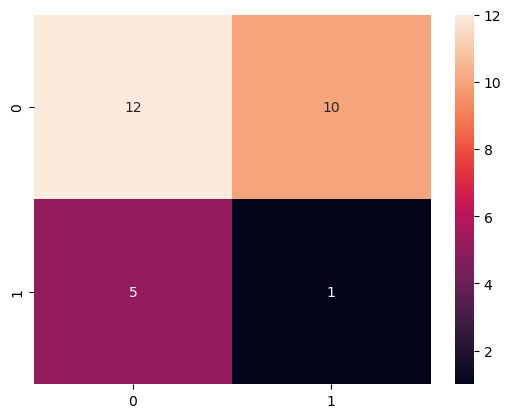

In [529]:
sns.heatmap(cm, annot=True)

In [522]:
f1score=f1_score(y_test, y_pred)

In [523]:
print(f1score)

0.11764705882352942


In [524]:
print(accuracy_score(y_test, y_pred))

0.4642857142857143


### 2) Using AdaBoost module from SkLearn 

In [497]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

In [562]:
dt = DecisionTreeClassifier(max_depth=1, criterion="gini") 
ada_boost = AdaBoostClassifier(base_estimator=dt, n_estimators=50)
ada_boost.fit(X_train, y_train)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))

In [563]:
y_pred_ada = ada_boost.predict(X_test)


In [564]:
accuracy = accuracy_score(y_test, y_pred_ada)
confusion = confusion_matrix(y_test, y_pred_ada)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(confusion)

Accuracy: 0.64
Confusion Matrix:
[[17  5]
 [ 5  1]]


In [565]:
f1score_ada=f1_score(y_test, y_pred_ada)

In [566]:
print(f1score_ada)

0.16666666666666666


In [567]:
print(accuracy_score(y_test, y_pred_ada))

0.6428571428571429


### Performance of AdaBoost model built from scratch and that of the model from scikit learn roughly matches in terms of accuracy and f1 score

With model built from scratch:

                Accuracy:0.46
                F1 Score:0.12
                
With model built with Sklearn:

                Accuracy:0.64
                F1 Score:0.167               